# TensorFlow Implementaton of Single Antigen NDE Fitting
This is an example python script to illustrate fitting a geospatial regression (GP noise) model for a single antigen using the NDE approximated likelihood model

## Step 1: Read in summarised TRaC data with matched covariates and build as TensorFlow constants 

- Age restricted to 1-50 y/o (to limit impact of maternal anti-bodies and limit look-back time)

- Sites snapped to land-sea mask boundary and standardised covariates extracted

- Area including Port-au-Prince and surrounds excluded (to limit impact of migration) 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.io import mmread
import osgeo.gdal as gdal
import os
import matplotlib.pyplot as plt
import pickle

# Start a tensorflow session
sess = tf.Session(config = tf.ConfigProto())
sess.run(tf.global_variables_initializer())

# Import the trac data
tracdata = pd.read_csv('../trac_data/summary_TRaC_data_with_covariates.csv')
tracdata[tracdata.Age < 51]

# Village positions
village_lats = tracdata.groupby(['Cluster_Num'])['Latitude'].unique().values
village_longs = tracdata.groupby(['Cluster_Num'])['Longitude'].unique().values

# Number of villages
Nvillages = tracdata.Cluster_Num.unique().size

# Extract the titres and ages for all individuals, grouped by village
titres = tf.constant(tracdata.MSP.values, dtype='float32')
ages = tf.constant(tracdata.Age.values, dtype='float32')
cluster_assignments = tf.constant(tracdata.Cluster_Num.values, dtype='int32')
init_latent_ys = tracdata.MSP.values
init_latent_ys[init_latent_ys<1] = 1
init_latent_ys = np.log(init_latent_ys)

# Number of individuals
Nindividuals = len(tracdata.Age.values)

# Extract the mean covariates in each cell
covariates = tracdata.groupby(['Cluster_Num'])['covariate_accessibility','covariate_AI','covariate_distTowater','covariate_elevation','covariate_forest','covariate_grass','covariate_urbanbarren','covariate_woodysavanna','covariate_OSM','covariate_PET','covariate_slope','covariate_TWI'].mean().values
covariates = tf.constant(covariates, dtype='float32')

# Number of covariates
Ncovariates = covariates.shape[1]

## Step 2: Read in weights from fitted NDE to set up approximate likelihood computation 

In [3]:
# Load in the batch normalizations for re-scaling inputs to the neural likelihood
f = open('simulations/simulations/model_2/batch_normalizations.pkl', 'rb')
xs_mean, xs_std, ps_mean, ps_std = pickle.load(f)
f.close()

# Data = individual titres re-scaled by batch norms for input to the neural likelihood
data_individual = (tf.expand_dims(titres,1)-xs_mean)/ xs_std

# Set-up for the neural density estimator:
# read in weights and biases, set the architecture (to same as the trained NDE)

# Load in the network weights and biases
f = open('simulations/simulations/model_2/network_weights.pkl', 'rb')
network_weights = pickle.load(f)
f.close()
f = open('simulations/simulations/model_2/network_biases.pkl', 'rb')
network_biases = pickle.load(f)
f.close()

# Declare weights and biases as tf.constants
weights = [tf.constant(network_weights[0], dtype='float32'), tf.constant(network_weights[1], dtype='float32'), tf.constant(network_weights[2], dtype='float32'), tf.constant(network_weights[3], dtype='float32'), tf.constant(network_weights[4], dtype='float32'), tf.constant(network_weights[5], dtype='float32'), tf.constant(network_weights[6], dtype='float32')]
biases = [tf.constant(network_biases[0], dtype='float32'), tf.constant(network_biases[1], dtype='float32'),  tf.constant(network_biases[2], dtype='float32'), tf.constant(network_biases[3], dtype='float32'), tf.constant(network_biases[4], dtype='float32'), tf.constant(network_biases[5], dtype='float32'),  tf.constant(network_biases[6], dtype='float32')]

# (Global) set-up parameters for the NDE
n_antibodies = 1 # number of antibodies
n_parameters = 10 + 1 # serology + log_eir
D = n_antibodies # size of data (number of antibodies)
P = n_parameters + 1 # number of parameters (num serology parameters + EIR + age)
M = 3 # number of Gaussian components
N = int((D + D * (D + 1) / 2 + 1)*M)
n_hidden = [27, 27, 27, 27, 27, 27, 27]
activations = [tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh]

# Functions for mapping the neural network output to the mixture model components

# Build lower triangular matrices (parameterizing the covariances) from network output (also calculate determinant)
def lower_triangular_matrix(σ):
    Σ = []
    det = []
    start = 0
    end = 1
    for i in range(D):
        exp_val = tf.exp(σ[:, :, end-1])
        det.append(exp_val)
        if i > 0:
            Σ.append(tf.pad(tf.concat([σ[:, :, start:end-1], tf.expand_dims(exp_val, -1)], -1), [[0, 0], [0, 0], [0, D-i-1]]))
        else:
            Σ.append(tf.pad(tf.expand_dims(exp_val, -1), [[0, 0], [0, 0], [0, D-i-1]]))
        start = end
        end += i + 2
    Σ = tf.transpose(tf.stack(Σ), (1, 2, 0, 3))
    det = tf.reduce_prod(tf.stack(det), 0)
    return Σ, det

# Split network output into component means, covariances and weights (also returns determinant of covariance)
def mapping(output_layer, M, D):
    μ, Σ, α = tf.split(output_layer, [M * D, M * D * (D + 1) // 2, M], 1)
    μ = tf.reshape(μ, (-1, M, D))
    Σ, det = lower_triangular_matrix(tf.reshape(Σ, (-1, M, D * (D + 1) // 2)))
    α = tf.nn.softmax(α)
    return μ, Σ, α, det

## Step 3: Set up priors for the log EIR and serology parameters

In [4]:
# Set-up prior for the log-field (here: iid noise)
log_range = tf.Variable(-1.0, dtype='float32')
log_sd = tf.Variable(1.0, dtype='float32')
prior_log_range = tfp.distributions.Normal(loc = -1.0, scale = 1.0)
prior_log_sd = tfp.distributions.Normal(loc = 1.0, scale = 1.0)

distsq_matrix = np.zeros((Nvillages,Nvillages))
for i in range(Nvillages):
    for j in range(Nvillages):
        distsq_matrix[i,j] = (village_lats[i]-village_lats[j])**2.0+(village_longs[i]-village_longs[j])**2.0

cov_matrix = tf.exp(log_sd*2.0)*tf.exp(-distsq_matrix/tf.exp(log_range*2.0)) + tf.eye(Nvillages)*0.1

log_field = tf.Variable(np.zeros(Nvillages), dtype='float32')
prior_log_field = tfp.distributions.MultivariateNormalFullCovariance(loc = tf.constant(np.zeros(Nvillages),dtype='float32'), covariance_matrix = cov_matrix)

# Slopes and intercept for linear predictor part of the model
slopes = tf.Variable(np.zeros(Ncovariates), dtype='float32')
prior_slopes = tfp.distributions.Normal(loc = 0.0, scale = 1.0)
intercept = tf.Variable(0.0, dtype='float32')
prior_intercept = tfp.distributions.Normal(loc = -3.0, scale = 1.0)

noise_prior_mean =  tfp.distributions.Normal(loc = 5.0 , scale = 5.0)
noise_prior_logsd =  tfp.distributions.Normal(loc = tf.constant(np.log(4.0), dtype='float32') , scale = 1.0)
noise_mean = tf.Variable(0.0, dtype='float32')
noise_logsd = tf.Variable(1.0, dtype='float32')

loghet = tf.Variable(np.zeros(1), dtype='float32')
loghet_prior = tfp.distributions.Normal(loc = tf.constant(np.log(0.75), dtype='float32'), scale = 0.0001)

# Serology hyper-parameters
serology_lower = tf.constant(np.array([
                          0, # fzero
                          0, # gzero
                          5, # azero
                          np.log(0.05), # logHetBoosting
                          np.log(10), # logBaselineBoostingFactor
                          np.log(10), # logBaselineBoostingThreshold
                          np.log(0.05), # logAttenuationFactor
                          2,# NAdultAntibodies
                          np.log(0.01), # logRhoChild
                          np.log(0.01) # logRhoAdultExtra
                          ]), dtype='float32')

serology_upper = tf.constant(np.array([
                          1, # fzero
                          1, # gzero
                          35, # azero
                          np.log(4), # logHetBoosting
                          np.log(30000), # logBaselineBoostingFactor
                          np.log(10000), # logBaselineBoostingThreshold
                          np.log(4), # logAttenuationFactor
                          20,# NAdultAntibodies
                          np.log(10), # logRhoChild
                          np.log(20) # logRhoAdultExtra
                          ]), dtype='float32')

prior_normal = tf.distributions.Normal(loc=0.0,scale=1.0)
serology_unbounded = tf.Variable(np.zeros(10), dtype='float32')
serology = tf.distributions.Normal(loc=0.0,scale=1.0).cdf(serology_unbounded)*(serology_upper-serology_lower)+serology_lower

## Step 4: Construct log posterior probability in tensorflow

In [5]:
# Linear predictor model for EIR: GP + C\beta + \beta_0
linear_predictor = log_field + intercept + tf.squeeze(tf.matmul(covariates,tf.expand_dims(slopes,1)))

linear_predictor_ind = tf.gather(linear_predictor, cluster_assignments-1)
ind_logeir_offset = tf.Variable(np.zeros(Nindividuals), dtype='float32')

soft_ind_logeir = -1.151293 + 6.907755*(tf.math.sigmoid((linear_predictor_ind+ind_logeir_offset - -1.15)/(6.907755/5))-0.5)

# Set up the parameters vector: list of (lambda_EIR, serology_parameters, age) for each individual
theta = (tf.concat([tf.expand_dims(soft_ind_logeir,1), # log EIR at the individuals locations
                                tf.transpose(tf.tile(tf.reshape(serology, [-1,1]), [1,Nindividuals])), # Shared serology parameters for all individuals
                                tf.transpose(tf.tile(tf.expand_dims(ages,0), [1,1]))], axis=1) - ps_mean)/ ps_std # Ages, and then shift and re-scale everything according to the batch normalization for the neural likelihood

# Set up the NDE likelihood
# Build the layers of the network
# First layer (input) is just the parameters
layers = [theta] 
# Now loop through the hidden layers
for i in range(len(n_hidden)):
    if i < len(n_hidden) - 1:
        layers.append(activations[i](tf.add(tf.matmul(layers[i], weights[i]), biases[i])))
    else:
        layers.append(tf.add(tf.matmul(layers[i], weights[i]), biases[i]))
# Map the output layer to mixture model parameters
μ, Σ, α, det = mapping(layers[-1], M, D)

# Compute the log likelihood
latent_log_y = tf.Variable(init_latent_ys, dtype='float32')
log_prob_latent_y = tf.reduce_sum(tf.log(tf.reduce_sum(tf.exp(-0.5*tf.reduce_sum(tf.square(tf.einsum("ijlk,ijk->ijl", Σ, tf.subtract(tf.expand_dims((tf.expand_dims(latent_log_y,1)-xs_mean)/ xs_std, 1), μ))), 2) + tf.log(α) + tf.log(det) - D*np.log(2. * np.pi) / 2.), 1) + 1e-37))
log_likelihood = tf.reduce_sum(tfp.distributions.Normal(loc = (tf.exp(latent_log_y)+noise_mean), scale = tf.exp(noise_logsd)).log_prob(titres))
                                                                                  
# Log prior over hyper-parameters and log-field (GP)
log_prior = tf.reduce_sum(prior_log_field.log_prob(log_field)) \
+ tf.reduce_sum(prior_slopes.log_prob(slopes)) \
+ prior_intercept.log_prob(intercept) \
+ tf.reduce_sum(prior_normal.log_prob(serology_unbounded)) \
+ loghet_prior.log_prob(loghet) \
+ tf.reduce_sum(tfp.distributions.Normal(loc = -tf.exp(loghet*2.0)/2.0, scale = tf.exp(loghet)).log_prob(ind_logeir_offset)) \
+ noise_prior_mean.log_prob(noise_mean) + noise_prior_logsd.log_prob(noise_logsd) \
+ prior_log_range.log_prob(log_range) + prior_log_sd.log_prob(log_sd)

# Negative log posterior
negative_log_posterior_prob = -(log_likelihood + log_prior[0] + log_prob_latent_y)

### Step 5: Construct Posterior and Single Parameter Std Devs

No idea why this HMC sampler is going in the wrong direction 
Copied from https://www.cs.toronto.edu/~radford/ham-mcmc-simple

In [ ]:
sess.run(tf.global_variables_initializer())

hmc_gradient = tf.gradients(negative_log_posterior_prob,[serology_unbounded,log_field,noise_mean,noise_logsd,latent_log_y,loghet,intercept,slopes,ind_logeir_offset])

epsilon = 10e-8
L = 1

for steps in range(100):    
    current_U = sess.run(negative_log_posterior_prob)
    current_q = sess.run([serology_unbounded,log_field,noise_mean,noise_logsd,latent_log_y,loghet,intercept,slopes,ind_logeir_offset])
    print(current_U, sess.run(serology))

    q = [[],[],[],[],[],[],[],[],[]]
    p = [[],[],[],[],[],[],[],[],[]]
    current_p = [[],[],[],[],[],[],[],[],[]]
    for i in range(9):
        q[i] = current_q[i]
        p[i] = np.random.normal(size=current_q[i].size)
        current_p[i] = p[i]

    for i in range(9):
        p[i] = p[i] - epsilon*sess.run(hmc_gradient)[i]/2.0

    for l in range(L):
        for i in range(9):
            q[i] = q[i] + epsilon*p[i]

        sess.run(serology_unbounded.assign(q[0]))
        sess.run(log_field.assign(q[1]))
        sess.run(noise_mean.assign(q[2][0]))
        sess.run(noise_logsd.assign(q[3][0]))
        sess.run(latent_log_y.assign(q[4]))
        sess.run(loghet.assign(q[5]))
        sess.run(intercept.assign(q[6][0]))
        sess.run(slopes.assign(q[7]))
        sess.run(ind_logeir_offset.assign(q[8]))
        if (l!=L):            
            for i in range(9):
                p[i] = p[i] - epsilon*sess.run(hmc_gradient)[i]

    for i in range(9):
        p[i] = p[i] - epsilon*sess.run(hmc_gradient)[i]/2.0

    current_K = 0.0
    for i in range(9): 
        current_K = current_K + np.sum(current_p[i]*current_p[i])/2.0
    proposed_U = sess.run(negative_log_posterior_prob)
    proposed_K = 0.0
    for i in range(9): 
        proposed_K = proposed_K + np.sum(p[i]*p[i])/2.0

    if (np.log(np.random.uniform(low=0,high=1,size=1)) < (current_U-proposed_U+current_K-proposed_K)):
        print("accepted", current_U, proposed_U, current_K, proposed_K)
    else:
        print("rejected", current_U, proposed_U, current_K, proposed_K)
        sess.run(serology_unbounded.assign(current_q[0]))
        sess.run(log_field.assign(current_q[1]))
        sess.run(noise_mean.assign(current_q[2]))
        sess.run(noise_logsd.assign(current_q[3]))
        sess.run(latent_log_y.assign(current_q[4]))
        sess.run(loghet.assign(current_q[5]))
        sess.run(intercept.assign(current_q[6]))
        sess.run(slopes.assign(current_q[7]))
        sess.run(ind_logeir_offset.assign(current_q[8]))

## Below is just code scraps

In [ ]:



admsero_u = tf.train.GradientDescentOptimizer(learning_rate=0.0000001).minimize(negative_log_posterior_prob)
sess.run(tf.global_variables_initializer())
sess.run(loghet.assign(np.ones(1)*np.log(0.75)))
for i in range(0,1000): 
    sess.run(admsero_u)
print(sess.run(negative_log_posterior_prob))


In [ ]:
sess.run(serology)

In [ ]:
sess.run(loghet)

In [ ]:


HMC = function (U, grad_U, epsilon, L, current_q)
{
  q = current_q
  p = rnorm(length(q),0,1)  # independent standard normal variates
  current_p = p

  # Make a half step for momentum at the beginning

  p = p - epsilon * grad_U(q) / 2

  # Alternate full steps for position and momentum

  for (i in 1:L)
  {
    # Make a full step for the position

    q = q + epsilon * p

    # Make a full step for the momentum, except at end of trajectory

    if (i!=L) p = p - epsilon * grad_U(q)
  }

  # Make a half step for momentum at the end.

  p = p - epsilon * grad_U(q) / 2

  # Negate momentum at end of trajectory to make the proposal symmetric

  p = -p

  # Evaluate potential and kinetic energies at start and end of trajectory

  current_U = U(current_q)
  current_K = sum(current_p^2) / 2
  proposed_U = U(q)
  proposed_K = sum(p^2) / 2

  # Accept or reject the state at end of trajectory, returning either
  # the position at the end of the trajectory or the initial position

  if (runif(1) < exp(current_U-proposed_U+current_K-proposed_K))
  {
    return (q)  # accept
  }
  else
  {
    return (current_q)  # reject
  }
}

In [ ]:
admsero_u = tf.train.AdagradOptimizer(learning_rate=0.1).minimize(negative_log_posterior_prob)
sess.run(tf.global_variables_initializer())
sess.run(loghet.assign(np.ones(1)*np.log(0.75)))
for i in range(0,100000): 
    sess.run(admsero_u)
print(sess.run(negative_log_posterior_prob))
print(sess.run(serology))

In [ ]:
print(sess.run(negative_log_posterior_prob))
print(sess.run(serology))

21101.975
[ 0.9985139   0.9865945  32.73771     1.0708585   4.4779615   9.20462
 -1.494281    2.2189357   0.80905056 -2.3816688 ]


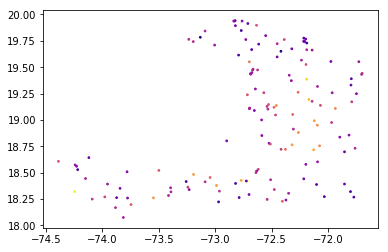

Sero Param Name : Posterior Mean : Posterior Std Dev
fzero 0.9985139 0.010570276550743761
gzero 0.9865945 0.03310087811312193
azero 32.73771 0.6211385629744015
HetBoosting 2.9178834 0.0077463869691006115
BaselineBoostingFactor 88.05499 0.9190060477268694
BaselineBoostingThreshold 9942.963 475.79312443375
logAttenuationFactor 0.22440988 0.021278187388170746
NpastAdultAntibodies 2.2189357 0.9140757374452253
RhoChild 2.2457747 0.017378387708530563
RhoAdult 2.338171 0.019172915753642047
Covariate Name: Posterior Mean : Posterior Std Dev
accessibility_to_cities_2015 0.047044277 0.005511456403103759
aridity_index 0.009621911 0.005803907560804118
DistToWater -0.0056912163 0.015770389874221594
Elevation -0.049360845 0.0054167365399917684
Landcover_forest -0.04175843 0.035509087139819304
Landcover_grass_savanna 0.05698783 0.03904109761977606
Landcover_urban_barren -0.024448128 0.017442876253517713
Landcover_woodysavanna -0.032217275 0.02150074850980496
openStreetMapv32 -0.046663422 0.0070603238

In [6]:
admsero_u = tf.train.AdagradOptimizer(learning_rate=1).minimize(negative_log_posterior_prob)
sess.run(tf.global_variables_initializer())
for i in range(0,10000): 
    sess.run(admsero_u)
print(sess.run(negative_log_posterior_prob))
print(sess.run(serology))

hessian_serology = sess.run(tf.hessians(negative_log_posterior_prob,serology))[0]
hessian_log_field = sess.run(tf.hessians(negative_log_posterior_prob,log_field))[0]
hessian_slopes = sess.run(tf.hessians(negative_log_posterior_prob,slopes))[0]

plt.scatter(village_longs, village_lats, c=sess.run(linear_predictor), s = 3, cmap="plasma") # check image coordinate transforms by comparing raster plot against observation locations 
plt.show()

print("Sero Param Name : Posterior Mean : Posterior Std Dev")
print("fzero",sess.run(serology)[0],np.sqrt(1.0/hessian_serology[0,0]))
print("gzero",sess.run(serology)[1],np.sqrt(1.0/hessian_serology[1,1]))
print("azero",sess.run(serology)[2],np.sqrt(1.0/hessian_serology[2,2]))
print("HetBoosting",np.exp(sess.run(serology)[3]),np.exp(sess.run(serology)[3])*np.sqrt(1.0/hessian_serology[3,3]))
print("BaselineBoostingFactor",np.exp(sess.run(serology)[4]),np.exp(sess.run(serology)[4])*np.sqrt(1.0/hessian_serology[4,4]))
print("BaselineBoostingThreshold",np.exp(sess.run(serology)[5]),np.exp(sess.run(serology)[5])*np.sqrt(1.0/hessian_serology[5,5]))
print("logAttenuationFactor",np.exp(sess.run(serology)[6]),np.exp(sess.run(serology)[6])*np.sqrt(1.0/hessian_serology[6,6]))
print("NpastAdultAntibodies",sess.run(serology)[7],np.sqrt(1.0/hessian_serology[7,7]))
print("RhoChild",np.exp(sess.run(serology)[8]),np.exp(sess.run(serology)[8])*np.sqrt(1.0/hessian_serology[8,8]))
print("RhoAdult",np.exp(sess.run(serology)[9])+np.exp(sess.run(serology)[8]),np.sqrt((np.exp(sess.run(serology)[8])*np.sqrt(1.0/hessian_serology[8,8]))**2.0+(np.exp(sess.run(serology)[9])*np.sqrt(1.0/hessian_serology[9,9]))**2.0))

print("Covariate Name: Posterior Mean : Posterior Std Dev")
print("accessibility_to_cities_2015",sess.run(slopes)[0],np.sqrt(1.0/hessian_slopes[0,0]))
print("aridity_index",sess.run(slopes)[1],np.sqrt(1.0/hessian_slopes[1,1]))
print("DistToWater",sess.run(slopes)[2],np.sqrt(1.0/hessian_slopes[2,2]))
print("Elevation",sess.run(slopes)[3],np.sqrt(1.0/hessian_slopes[3,3]))
print("Landcover_forest",sess.run(slopes)[4],np.sqrt(1.0/hessian_slopes[4,4]))
print("Landcover_grass_savanna",sess.run(slopes)[5],np.sqrt(1.0/hessian_slopes[5,5]))
print("Landcover_urban_barren",sess.run(slopes)[6],np.sqrt(1.0/hessian_slopes[6,6]))
print("Landcover_woodysavanna",sess.run(slopes)[7],np.sqrt(1.0/hessian_slopes[7,7]))
print("openStreetMapv32",sess.run(slopes)[8],np.sqrt(1.0/hessian_slopes[8,8]))
print("PotentialEvapoTranspiration",sess.run(slopes)[9],np.sqrt(1.0/hessian_slopes[9,9]))
print("Slope",sess.run(slopes)[10],np.sqrt(1.0/hessian_slopes[10,10]))
print("TopologicalWetnessIndex",sess.run(slopes)[11],np.sqrt(1.0/hessian_slopes[11,11]))

print("Heterogeneity: ",np.exp(sess.run(loghet)))
print("Noise Mean: ",sess.run(noise_mean))
print("Noise Std Dev: ",np.exp(sess.run(noise_logsd)))
print("GP Range: ",np.exp(sess.run(log_range)))
print("GP Scale: ",np.exp(sess.run(log_sd)))

In [ ]:
print("GP Scale: ",np.exp(sess.run(log_sd)))

In [ ]:
sess.run(tf.gradients(negative_log_posterior_prob,serology))

In [ ]:
sess.run(tf.gradients(negative_log_posterior_prob,serology))

In [ ]:
sess.run(log_prior)[0]

In [ ]:
sess.run(ind_logeir_offset)

In [ ]:
sess.run(soft_ind_logeir)